In [2]:
# Runtime/Change runtime type/GPU
# Tensorflow 2.0.0
!pip install --upgrade tensorflow-gpu

     |████████████████████████████████| 380.8MB 42kB/s 
     |████████████████████████████████| 450kB 52.6MB/s 
     |████████████████████████████████| 3.8MB 38.1MB/s 
     |████████████████████████████████| 81kB 12.6MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goog

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
# Import Graphviz
!apt install -y graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [0]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Use this libraries for preparing data
from PIL import Image
import os

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix

%matplotlib inline

# Exercise 2 - Transfer learning

### Prepare data

In [4]:
# Run this code to load the cifar10 dataset. We save this images on the drive so we don't need to load this images again.

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('training input shape : ', X_train.shape)
print('training output shape: ', y_train.shape)
print('testing input shape  : ', X_test.shape)
print('testing output shape : ', y_test.shape)


170500096/170498071 [==============================] - 4s 0us/step
training input shape :  (50000, 32, 32, 3)
training output shape:  (50000, 1)
testing input shape  :  (10000, 32, 32, 3)
testing output shape :  (10000, 1)


In [5]:
# Run this code section to connect your google drive with google colaboratory

from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
# Run this code section only if you have no such directory file

os.chdir('/content/gdrive/My Drive')
print(os.getcwd())

os.mkdir('TSM_DeLearn_PW10')
os.mkdir('TSM_DeLearn_PW10/data')
os.mkdir('TSM_DeLearn_PW10/data/train')
os.mkdir('TSM_DeLearn_PW10/data/test')

for c in range(10):
  os.mkdir('TSM_DeLearn_PW10/data/train/{}'.format(c))
  os.mkdir('TSM_DeLearn_PW10/data/test/{}'.format(c))


/content/gdrive/My Drive


In [0]:
# Run this code section only if you have not yet saved the images

index = 0
for i,im in enumerate(X_train):
  image = Image.fromarray(im)
  image.save("TSM_DeLearn_PW10/data/train/{}/{}.jpeg".format(y_train[i][0], index))
  index += 1
  
index = 0
for i,im in enumerate(X_test):
  image = Image.fromarray(im)
  image.save("TSM_DeLearn_PW10/data/test/{}/{}.jpeg".format(y_test[i][0], index))
  index += 1


### Experiment with pre-trained architectures on ImageNet

#### MobileNetV2

In [0]:
# libraries
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [9]:
pt_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160,3))
print('model loaded')
pt_model.trainable = True

9412608/9406464 [==============================] - 1s 0us/step
model loaded


In [10]:
model = Sequential([
  pt_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  #Flatten(),
  Dense(100),
  Dropout(0.5),
  Activation('relu'),
  Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

#%%
def preprocess_img(image):
  return (image/127.5) - 1
#%%

B = 32
data_gen = ImageDataGenerator(preprocessing_function=preprocess_img)
batches = data_gen.flow_from_directory('TSM_DeLearn_PW10/data/train', target_size=(160, 160), batch_size=B, shuffle=True) 
val_batches = data_gen.flow_from_directory('TSM_DeLearn_PW10/data/test', target_size=(160, 160), batch_size=B , shuffle=False)
log = model.fit_generator(batches,
                          steps_per_epoch=50000/B,
                          epochs=5,
                          validation_data=val_batches,
                          validation_steps=10000/B)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               128100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 2,387,094
Trainable params: 2,352,982
Non-trainable params: 34,112
_________________________________________

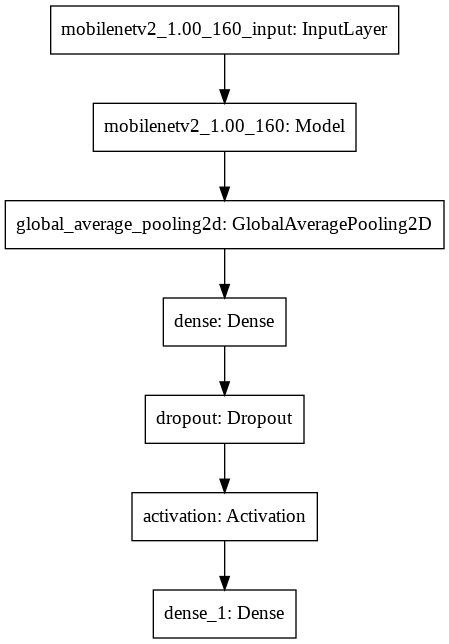

In [11]:
plot_model(model)

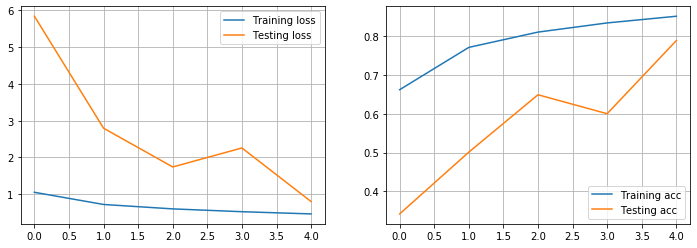

In [12]:
# Loss evaluation during training
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [14]:
# Model evaluation
loss_test, metric_test = model.evaluate_generator(val_batches, verbose=0) # ... evaluate model performance on test set
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.8000420258579829
Test accuracy: 0.789


#### InceptionResNetV2

In [15]:
pt_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(160, 160,3))
print('model loaded')
pt_model.trainable = True

219062272/219055592 [==============================] - 435s 2us/step
model loaded


In [16]:
model = Sequential([
  pt_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  #Flatten(),
  Dense(100),
  Dropout(0.5),
  Activation('relu'),
  Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

#%%
def preprocess_img(image):
  return (image/127.5) - 1
#%%

B = 32
data_gen = ImageDataGenerator(preprocessing_function=preprocess_img)
batches = data_gen.flow_from_directory('TSM_DeLearn_PW10/data/train', target_size=(160, 160), batch_size=B, shuffle=True) 
val_batches = data_gen.flow_from_directory('TSM_DeLearn_PW10/data/test', target_size=(160, 160), batch_size=B , shuffle=False)
log = model.fit_generator(batches,
                          steps_per_epoch=50000/B,
                          epochs=5,
                          validation_data=val_batches,
                          validation_steps=10000/B)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 3, 3, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               153700    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
activation_204 (Activation)  (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 54,491,446
Trainable params: 54,430,902
Non-trainable params: 60,544
_____________________________________

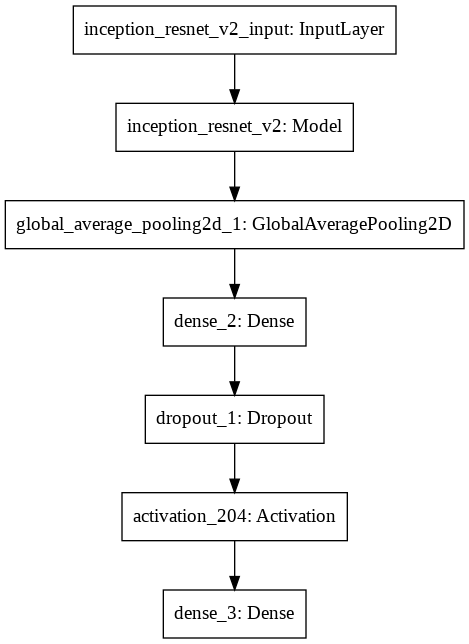

In [17]:
plot_model(model)

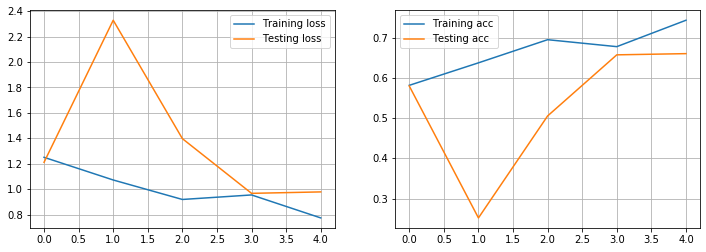

In [18]:
# Loss evaluation during training
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [19]:
# Model evaluation
loss_test, metric_test = model.evaluate_generator(val_batches, verbose=0) # ... evaluate model performance on test set
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.9773987838254569
Test accuracy: 0.6616


This models may be better than our model but also more time-consuming. The first model has a test accuracy of **0.789** after 5 epochs. Our model in PW08 had a accuracy of **~0.82** after 30 epochs.  